# Project 2: Time Series Analysis

In [1]:
# Some important libraries to use in time sereies analysis
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels as statsmodels
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
from pandasdmx import Request
import pandas as pd
import os
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)


# Setting fixed figure size
plt.rcParams['figure.figsize'] = [10, 7.5]
plt.rcParams.update({'font.size': 18})


#### Importing Lake Huron Data and Plotting it

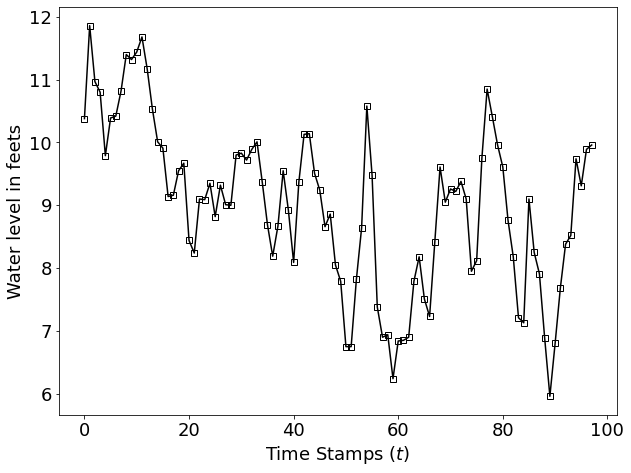

In [2]:
# Obtaining path to data and getting the data
filepath = os.getcwd()
datapath = filepath +"/Data/lakedata.xlsx"
figurepath = filepath+"/Figures"
df = pd.read_excel(datapath)

#plotting data as numpy arrays
data = df.iloc[:,0].to_numpy()
dataTime = np.arange(0,data.shape[0])
plt.figure()
plt.plot(dataTime, data,"k", marker='s', markerfacecolor='none')
plt.xlabel("Time Stamps $(t)$")
plt.ylabel("Water level in feets")

#save figure
plt.savefig(figurepath+"/lakedata.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Using Statsmodels to get autocovariance and plot them

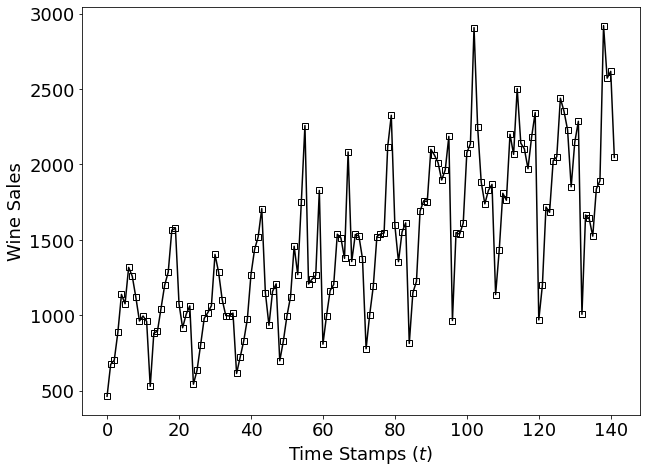

In [3]:
datapathwine = filepath +"/Data/winedata.xlsx"
dfwine = pd.read_excel(datapathwine)

#plotting data as numpy arrays
datawine = dfwine.iloc[:,0].to_numpy()
dataTimeWine = np.arange(0,datawine.shape[0])
plt.figure()
plt.plot(dataTimeWine, datawine,"k", marker='s', markerfacecolor='none')
plt.xlabel("Time Stamps $(t)$")
plt.ylabel("Wine Sales")

#save figure
plt.savefig(figurepath+"/winedata.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Stationary Time Series

### Augmented Dickey-Fuller Test for Stanionarity 
Lets test the Lake Huron Data using ADFT. $-3.89767 < \text{min}[-3.50038, -2.89215, 2.58310]$  and $p-$ value $< 0.05$ so the data series is stationary.

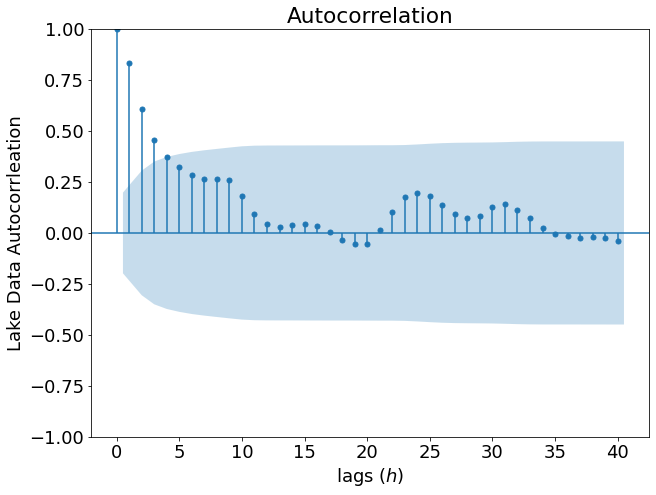

In [4]:
#plotting data as numpy arrays
plot_acf(data, lags =40)
plt.xlabel("lags $(h)$")
plt.ylabel("Lake Data Autocorrleation")

#save figure
plt.savefig(figurepath+"/lakedataautocorr.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [5]:
#Checking if the data is stationary
result = adfuller(data)
# Print test statistic
print(result)

(-3.8976683843687763, 0.0020520736790759007, 1, 96, {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}, 179.33694888946826)


### Making TS stationary using method of differences
In this section we will make the wine data stationary. Lets first check out the autocorrleation plot and then apply ADFT

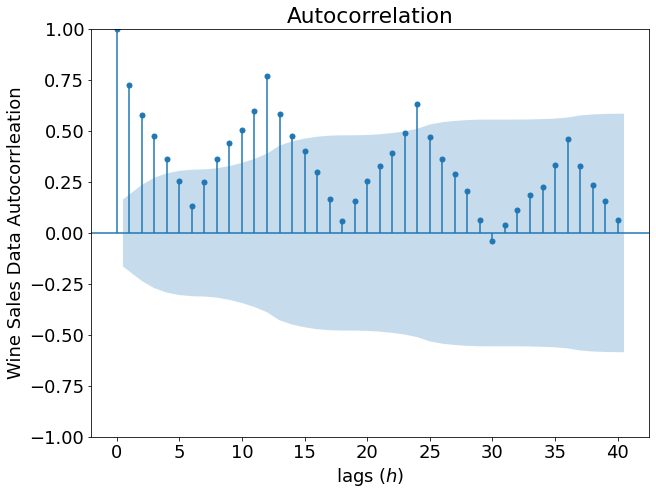

In [6]:
#plotting data as numpy arrays
winedata = dfwine.iloc[:,0].to_numpy()
winedataTime = np.arange(0,data.shape[0])
plot_acf(winedata, lags =40)
plt.xlabel("lags $(h)$")
plt.ylabel("Wine Sales Data Autocorrleation")

#save figure
plt.savefig(figurepath+"/wineautocov.pdf", format="pdf", bbox_inches="tight")
plt.show()


For the wine data, we can see that @5% $T_{\text{stat}} > \text{CV}$ and $p-$value $> 0.05$ so we can not reject the Null Hypothesis and the time series has a unit root i.e not stationary.

In [7]:
#Checking if the data is stationary
result = adfuller(datawine)
# Print test statistic
print(result)

(-0.33518213170815725, 0.9203715733448994, 12, 129, {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}, 1741.262969509912)


### Converting Non-stationary time series to Stationary Time series
We will use differencing to make the series stationary.

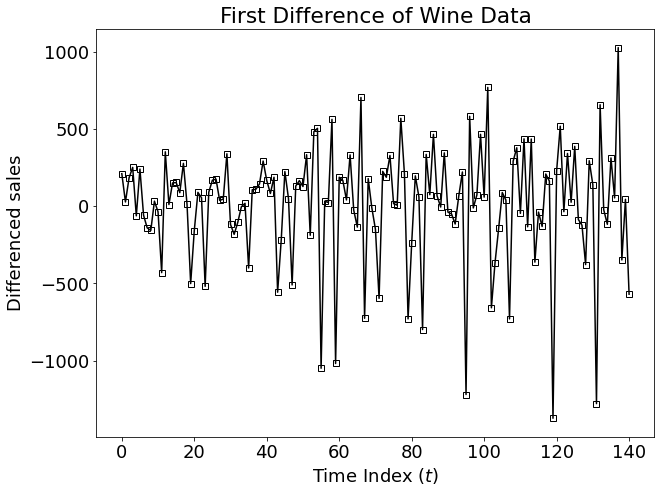

In [8]:
winedata_diff = datawine[1:] - datawine[0:-1]
plt.plot( winedata_diff,  "k", marker='s', markerfacecolor='none')
plt.title('First Difference of Wine Data')
plt.ylabel("Differenced sales")
plt.xlabel("Time Index $(t)$")
#save figure
plt.savefig(figurepath+"/winediff.pdf", format="pdf", bbox_inches="tight")
plt.show()

The series is now stationary.

In [9]:
#ADF test
result = adfuller(winedata_diff)
print(result)

(-7.062330134489904, 5.185082140858271e-10, 11, 129, {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}, 1726.8070536354278)


# Simulating ARMA process 


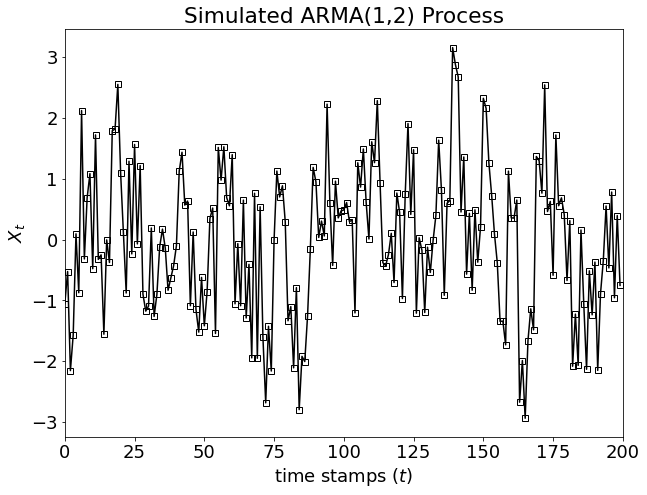

In [10]:

# Forming AR and MA coefficients
ar_pol = np.array([1,- 0.5])
ma_pol = np.array([1, 0, 0.25])
ARMA_1 = ArmaProcess(ar_pol,ma_pol).generate_sample(nsample=200)


# Plotting 
plt.plot(ARMA_1,"k", marker='s', markerfacecolor='none')
plt.title('Simulated ARMA(1,2) Process')
plt.xlim([0,200])
plt.ylabel("$X_t$")
plt.xlabel("time stamps $(t)$")
plt.savefig(figurepath+"/generalARMA.pdf", format="pdf", bbox_inches="tight")
plt.show()

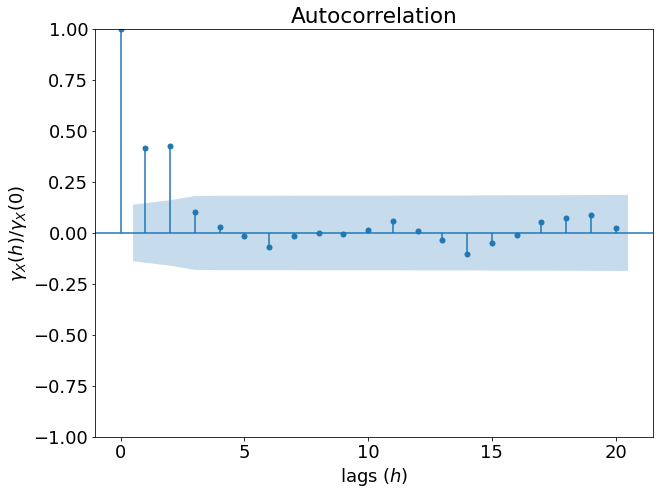

In [11]:
#plot ACVF
plot_acf(ARMA_1, lags =20)
plt.xlabel("lags $(h)$")
plt.ylabel("$\gamma_X(h) / \gamma_X(0)$")
plt.savefig(figurepath+"/armacorr.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Fiting $\text{MA(n)}$ model

#### We can simulate MA series by sepcifing MA and AR polynomial coefficients.

In [12]:
plt.rcParams.update({'font.size': 18})

ar1 = np.array([1,0])
ma1 = np.array([1, 0, 2])
MA = ArmaProcess(ar1,ma1).generate_sample(nsample=200)

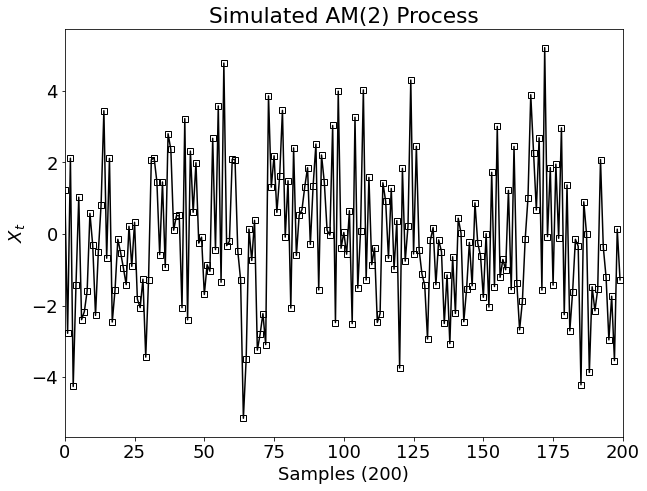

In [13]:
plt.plot( MA,  "k", marker='s', markerfacecolor='none')
plt.title('Simulated AM(2) Process')
plt.xlim([0,200])
plt.ylabel("$X_t$")
plt.xlabel("Samples (200)")
#save figure
plt.savefig(figurepath+"/MA2.pdf", format="pdf", bbox_inches="tight")
plt.show()

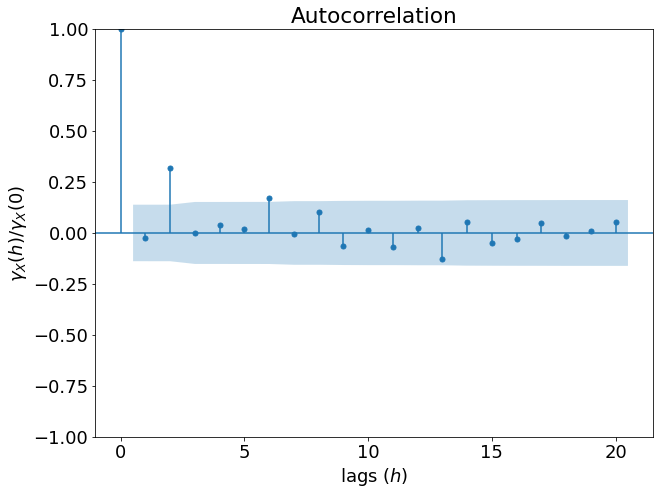

In [14]:
#plot ACVF
plot_acf(MA, lags =20)
plt.xlabel("lags $(h)$")
plt.ylabel("$\gamma_X(h) / \gamma_X(0)$")
plt.savefig(figurepath+"/MA2corr.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### We can alo grab the information and plot it in style we prefer.

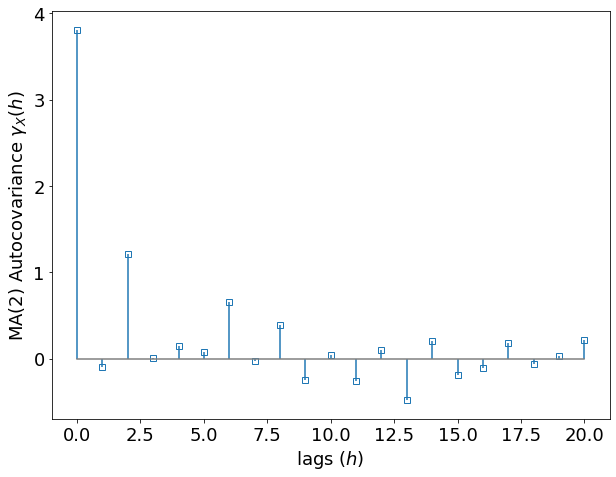

In [15]:
simulated_acv = statsmodels.tsa.stattools.acovf(MA,nlag =20)
markerline, stemlines, baseline = plt.stem(range(len(simulated_acv)),simulated_acv, markerfmt="s", basefmt="C7")
markerline.set_markerfacecolor('None')
plt.xlabel("lags $(h)$")
plt.ylabel("MA(2) Autocovariance $\gamma_X(h)$")
plt.savefig(figurepath+"/MA2covCustom.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Statsmodels can also calculate theoretical ACVF

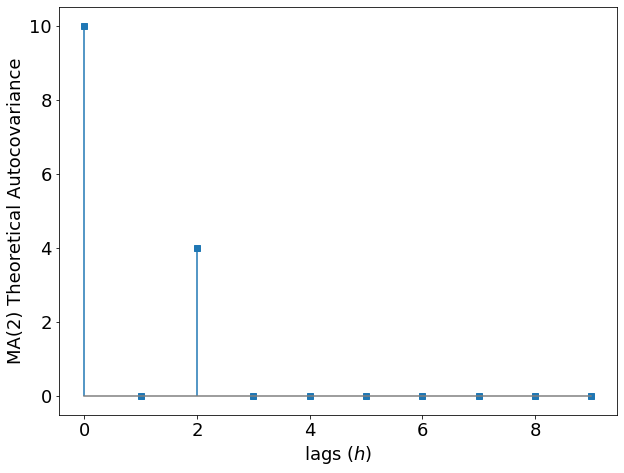

In [16]:
acvf = statsmodels.tsa.arima_process.arma_acovf(ar1, ma1, nobs=10, sigma2=2, dtype=None)
plt.stem(range(len(acvf)),acvf, markerfmt='s',  basefmt="C7")
plt.xlabel("lags $(h)$")
plt.ylabel("MA(2) Theoretical Autocovariance")
plt.savefig(figurepath+"/MA2theoreticalACVF.pdf", format="pdf", bbox_inches="tight")
plt.show()

### MA Fit of Lake Huron Data

Check for Stationarity using Dicky-Fuller Test

In [17]:
#Checking if the data is stationary
result = adfuller(data)
# Print test statistic
print(result)


(-3.8976683843687763, 0.0020520736790759007, 1, 96, {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}, 179.33694888946826)


### Forecasting out of sample data.

In [18]:
modelMA = ARIMA(data[0:-1], order=(0,0,2)) 
resultsMA = modelMA.fit()

# Make predictions for the test set
forecastMA = resultsMA.predict(start=0, end=97)
## get MSE
MSE_MA =((data - forecastMA)**2).mean()

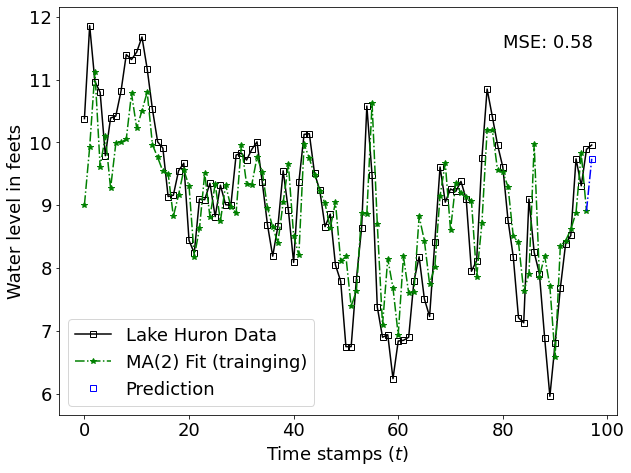

In [19]:
predtimes = np.arange(0,len(forecastMA))
plt.figure()
plt.plot(dataTime, data,  "k", marker='s', markerfacecolor='none')
plt.plot(predtimes[0:-1], forecastMA[0:-1], 'g*-.')
plt.plot(predtimes[-1], forecastMA[-1], 'bs', markerfacecolor='none')
plt.plot(predtimes[-2:], forecastMA[-2:], 'b-.') 
plt.xlabel("Time stamps $(t)$")
plt.ylabel("Water level in feets")
plt.legend(["Lake Huron Data", "MA(2) Fit (trainging)", "Prediction"])
plt.text(80, 11.5, "MSE: {:.2f}".format(MSE_MA))
plt.savefig(figurepath+"/LakeMA2fit.pdf", format="pdf", bbox_inches="tight")

#save figure
plt.show()

In [20]:
# Model summary
print(resultsMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   97
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -110.791
Date:                Fri, 14 Jul 2023   AIC                            229.581
Time:                        17:32:46   BIC                            239.880
Sample:                             0   HQIC                           233.745
                                 - 97                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0077      0.197     45.702      0.000       8.621       9.394
ma.L1          1.0136      0.090     11.252      0.000       0.837       1.190
ma.L2          0.5007      0.102      4.900      0.0

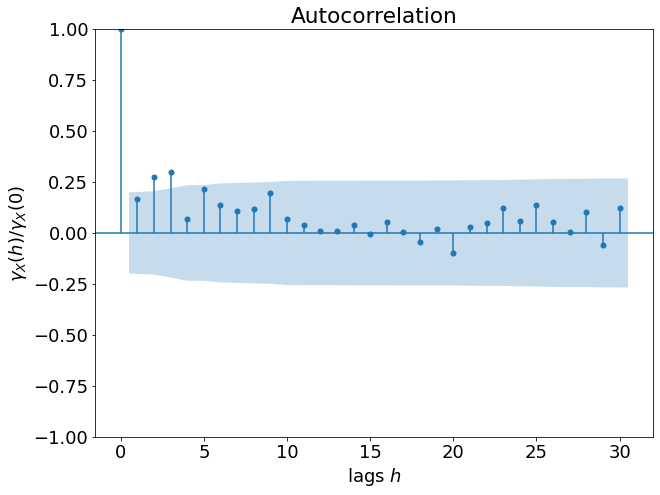

In [21]:
plot_acf(resultsMA.resid,lags = 30)
plt.xlabel("lags $h$")
plt.ylabel("$\gamma_X(h)/\gamma_X(0)$")
plt.savefig(figurepath+"/MA2fitcorr.pdf", format="pdf", bbox_inches="tight")

plt.show()

Note that most of the lb_pvalue are below 0.05,hence the residuals are not IID, this can also be deduced from the autocorrelation $\rho_X(h)$ plot given there are more than one significant autocorrelation.

In [22]:
# Ljung-Box test of MA model
result = acorr_ljungbox(resultsMA.resid)
print(result)

      lb_stat  lb_pvalue
1    2.838493   0.092030
2   10.407859   0.005495
3   19.439281   0.000222
4   19.936322   0.000514
5   24.753113   0.000155
6   26.691181   0.000165
7   27.945525   0.000225
8   29.421509   0.000267
9   33.543600   0.000107
10  34.088250   0.000178


# Fitting an $\text{AR}(n)$ model
We will first look at simulating an AR(1) process.

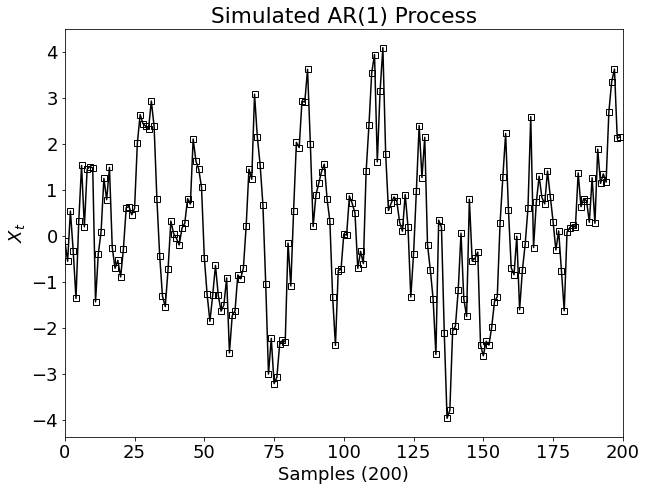

In [23]:
ar2 = np.array([1,-0.8])
ma2 = np.array([1, 0])
AR = ArmaProcess(ar2,ma2).generate_sample(nsample=200)
plt.plot( AR,  "k", marker='s', markerfacecolor='none')
plt.title('Simulated AR(1) Process')
plt.xlim([0,200])
plt.ylabel("$X_t$")
plt.xlabel("Samples (200)")
#save figure
plt.savefig(figurepath+"/AR1.pdf", format="pdf", bbox_inches="tight")
plt.show()

Lets have a look at the autocovariance.

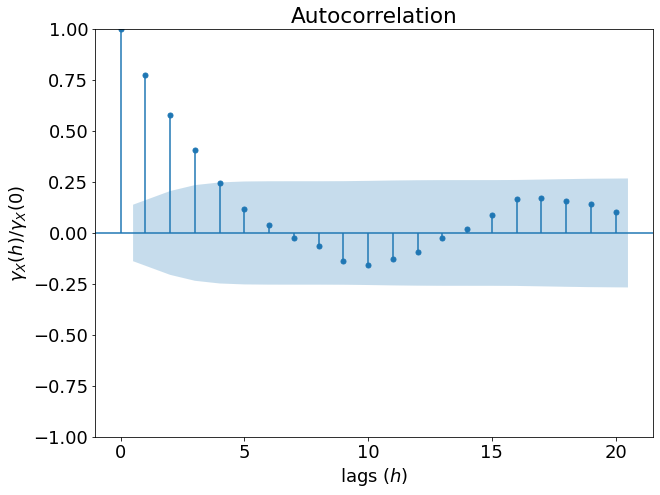

In [24]:
#plot ACVF
plot_acf(AR, lags =20)
plt.xlabel("lags $(h)$")
plt.ylabel("$\gamma_X(h) / \gamma_X(0)$")
plt.savefig(figurepath+"/AR1corr.pdf", format="pdf", bbox_inches="tight")
plt.show()

Lets fit an AR(2) model to Lake Huron 

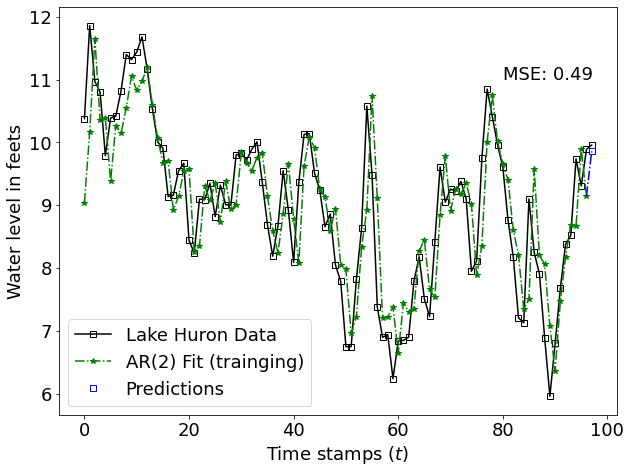

In [25]:
modelAR = ARIMA(data[0:-1], order=(2,0,0)) 
resultsAR = modelAR.fit()
# Make predictions for the test set
forecastAR = resultsAR.predict(start=0, end=97)
MSE_AR =((data - forecastAR)**2).mean()

predtimes = np.arange(0,len(forecastAR))
plt.figure()
plt.plot(dataTime, data,  "k", marker='s', markerfacecolor='none')
plt.plot(predtimes[0:-1], forecastAR[0:-1], 'g*-.')
#connect the plots
plt.plot(predtimes[-1], forecastAR[-1], 'bs', markerfacecolor='none')
plt.plot(predtimes[-2:], forecastAR[-2:], 'b-.') 
plt.xlabel("Time stamps $(t)$")
plt.ylabel("Water level in feets")
plt.legend(["Lake Huron Data", "AR(2) Fit (trainging)", "Predictions"])
plt.text(80, 11, "MSE: {:.2f}".format(MSE_AR))
#save figure
plt.savefig(figurepath+"/LakeAR2fit.pdf", format="pdf", bbox_inches="tight")

plt.show()


In [26]:
# Model summary
print(resultsAR.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   97
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -103.070
Date:                Fri, 14 Jul 2023   AIC                            214.139
Time:                        17:32:49   BIC                            224.438
Sample:                             0   HQIC                           218.304
                                 - 97                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0426      0.348     26.004      0.000       8.361       9.724
ar.L1          1.0423      0.092     11.299      0.000       0.861       1.223
ar.L2         -0.2486      0.091     -2.722      0.0

AR(2) gives us WN residuals (uncorrelated) as shown by the Ljung-box test and the Autocorrelation plot.

In [27]:
# Ljung-Box test of AR model
result = acorr_ljungbox(resultsAR.resid)
print(result)

     lb_stat  lb_pvalue
1   0.262734   0.608248
2   0.933876   0.626919
3   1.039064   0.791801
4   1.087228   0.896293
5   1.817928   0.873721
6   1.836095   0.934139
7   1.838618   0.968230
8   1.892755   0.984125
9   6.304625   0.709085
10  6.394110   0.781137


 Plot of the residuals after fitting AR model

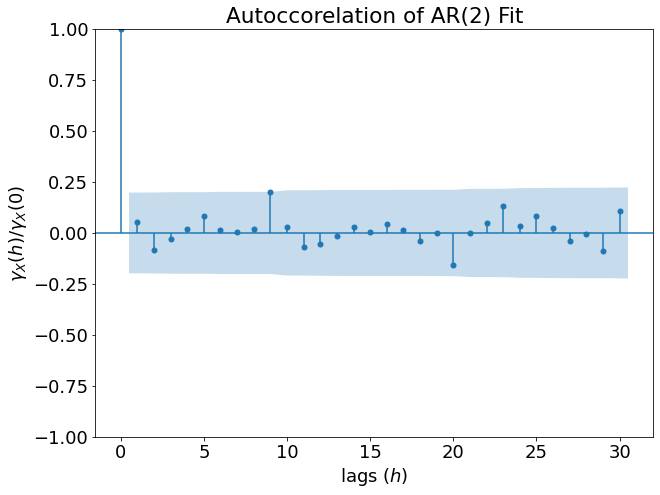

In [28]:
plot_acf(data - forecastAR, lags =30)
plt.xlabel("lags $(h)$")
plt.ylabel("$\gamma_X(h) / \gamma_X(0)$")
plt.title("Autoccorelation of AR(2) Fit")
#save figure
plt.savefig(figurepath+"/AR2fitcorr.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Fitting an $\text{ARMA}(p,q)$ model.
We use a brute force method to find the orders p and q inorder find the best p,q that minimizes our AIC parameter.

In [29]:
def optimize_ARIMA(order_list, data_in):
    """
        Return dataframe with parameters and corresponding AIC
        order_list: list with (p, d, q) tuples. d is fixed
        data_in:    Time Series Data
    """
    
    results = []
    
    for order in order_list:
        try: 
            model = ARIMA(data_in, order=order).fit()
        except:
            continue
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


In [30]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
# Create a list with all possible combination of parameters
parameters = [(a, b) for a in ps for b in qs]

parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1,0)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, data[0:-1])
result_df

c:\Users\yassy\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yassy\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


,"(p, d, q)",AIC
0,"(1, 0, 1)",213.391727
1,"(2, 0, 0)",214.139305
2,"(3, 0, 0)",214.942930
3,"(1, 0, 2)",215.364390
4,"(2, 0, 1)",215.377056
5,"(3, 0, 1)",216.300170
6,"(1, 0, 3)",216.769895
7,"(2, 0, 2)",216.917087
8,"(1, 0, 0)",217.951999
9,"(3, 0, 2)",218.300128


In [31]:
best_model = ARIMA(data[0:-1], order=(1,0,1)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   97
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -102.696
Date:                Fri, 14 Jul 2023   AIC                            213.392
Time:                        17:32:54   BIC                            223.691
Sample:                             0   HQIC                           217.556
                                 - 97                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0549      0.363     24.971      0.000       8.344       9.766
ar.L1          0.7448      0.083      8.963      0.000       0.582       0.908
ma.L1          0.3202      0.099      3.247      0.0

In [32]:
# Ljung-Box test
result = acorr_ljungbox(best_model.resid)
print(result)

     lb_stat  lb_pvalue
1   0.071854   0.788656
2   0.112311   0.945392
3   0.421541   0.935758
4   0.425217   0.980361
5   0.831145   0.975004
6   0.831765   0.991195
7   0.863825   0.996737
8   0.879937   0.998899
9   4.950767   0.838579
10  4.992041   0.891709


Lets make out of sample predictions 

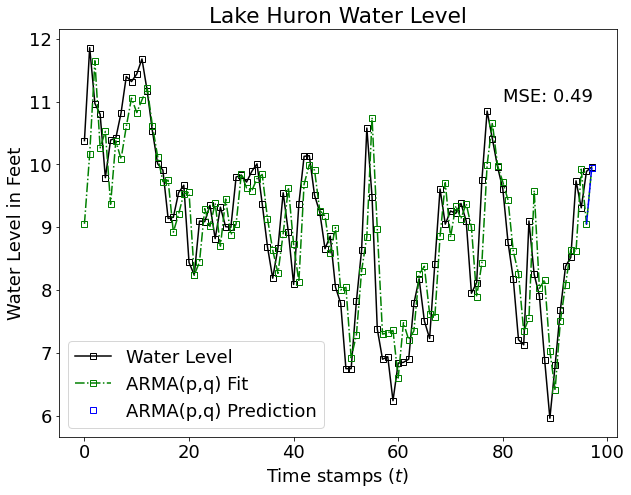

In [33]:
# Make predictions for the test set
forecastARMA = best_model.predict(start=0, end=97)
MSE_ARMA =((data - forecastARMA)**2).mean()
predtimes = np.arange(0,len(forecastARMA))

plt.figure()
plt.plot(dataTime, data,  "k", marker='s', markerfacecolor='none')
plt.plot(predtimes, forecastARMA, 'g-.',marker='s', markerfacecolor='none') 
plt.plot(predtimes[-1], forecastARMA[-1], 'bs', markerfacecolor='none')
plt.plot(predtimes[-2:], forecastARMA[-2:], 'b-.') 
plt.xlabel("Time stamps $(t)$")
plt.ylabel("Water Level in Feet")
plt.legend(["Water Level", "ARMA(p,q) Fit", "ARMA(p,q) Prediction"])
plt.title("Lake Huron Water Level")
plt.text(80, 11, "MSE: {:.2f}".format(MSE_ARMA))
#save figure
plt.savefig(figurepath+"/LakeARMAfit.pdf", format="pdf", bbox_inches="tight")

plt.show()

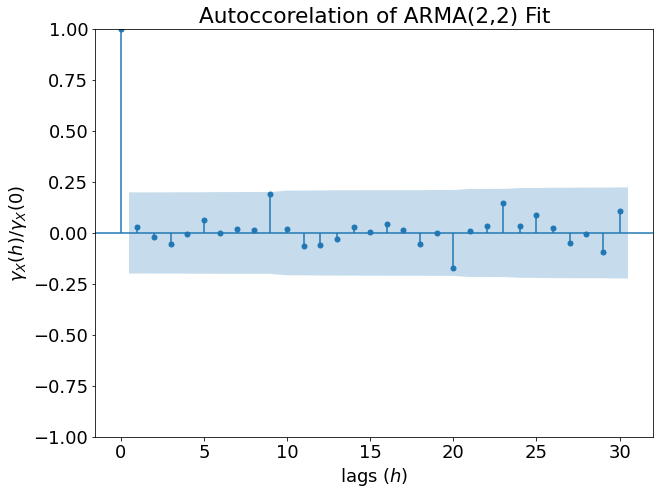

In [34]:
#Plotting ARMA residuals
plot_acf(best_model.resid, lags =30)
plt.xlabel("lags $(h)$")
plt.ylabel("$\gamma_X(h) / \gamma_X(0)$")
plt.title("Autoccorelation of ARMA(2,2) Fit")
#save figure
plt.savefig(figurepath+"/ARMAfitcorr.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Putting it All together
Lets have a look at the Earnings per share data of Johnson & Johnson

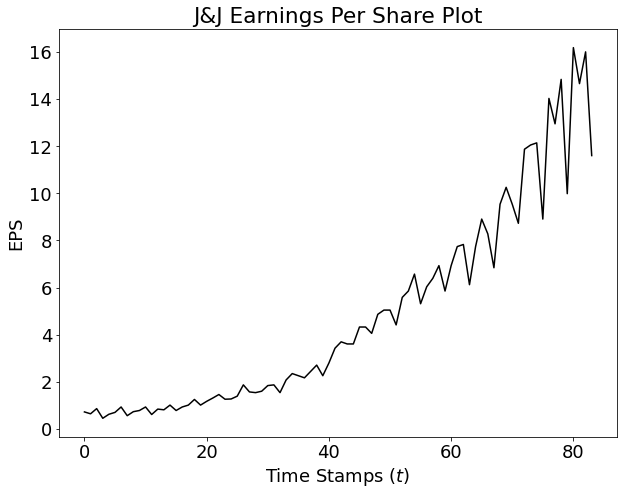

In [35]:
datapathJNJ = filepath +"/Data/jnj.xlsx"
df = pd.read_excel(datapathJNJ)

#plotting data as numpy arrays
dataJNJ = df.iloc[:,1].to_numpy()
datatTimeJNJ = np.arange(0,dataJNJ.shape[0])
plt.figure()
plt.plot(datatTimeJNJ, dataJNJ,"k", markerfacecolor='none')
plt.xlabel("Time Stamps $(t)$")
plt.title("J&J Earnings Per Share Plot")
plt.ylabel("EPS")

#save figure
plt.show()

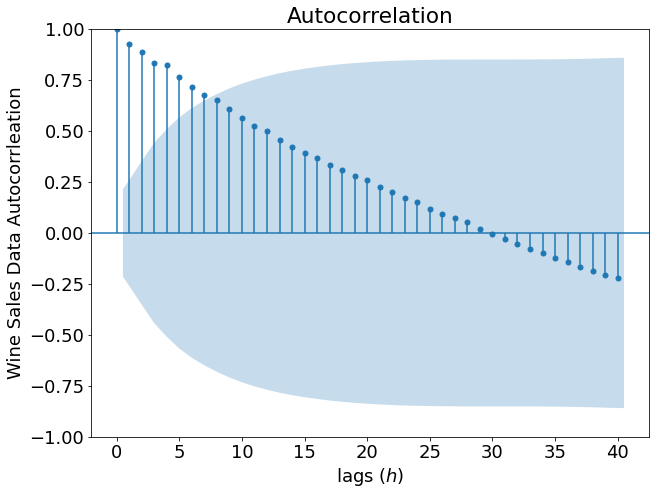

In [36]:
#plotting data as numpy arrays
plot_acf(dataJNJ, lags =40)
plt.xlabel("lags $(h)$")
plt.ylabel("Wine Sales Data Autocorrleation")

#save figure
plt.show()

In [37]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
# Create a list with all possible combination of parameters
parameters = [(a, b) for a in ps for b in qs]
dataJNJ_log =np.log(dataJNJ)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, dataJNJ_log[0:-4])
result_df


c:\Users\yassy\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yassy\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p, d, q)",AIC
0,"(4, 1, 3)",-132.545878
1,"(4, 1, 1)",-131.948423
2,"(4, 1, 2)",-130.983989
3,"(4, 1, 4)",-130.472001
4,"(4, 1, 0)",-118.962487
5,"(3, 1, 4)",-111.954789
6,"(3, 1, 3)",-108.014772
7,"(3, 1, 2)",-98.962518
8,"(1, 1, 4)",-87.134463
9,"(2, 1, 4)",-85.483566


In [38]:
best_model = ARIMA(dataJNJ_log[0:-2], order=(4,1,3)).fit()
print(best_model.summary())

c:\Users\yassy\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   82
Model:                 ARIMA(4, 1, 3)   Log Likelihood                  77.256
Date:                Fri, 14 Jul 2023   AIC                           -138.511
Time:                        17:33:04   BIC                           -119.356
Sample:                             0   HQIC                          -130.826
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0035      0.061      0.057      0.954      -0.115       0.122
ar.L2          0.0161      0.051      0.317      0.751      -0.083       0.115
ar.L3          0.0223      0.049      0.451      0.6

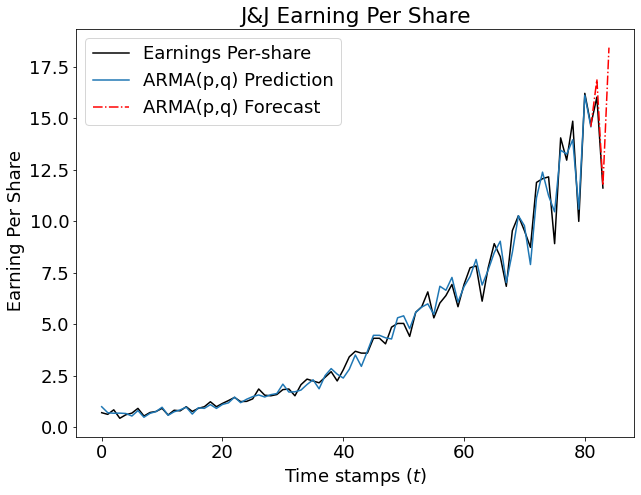

In [41]:
# Make predictions for the test set
end =  dataJNJ_log.shape[0]
forecastARMA = best_model.predict(start=0, end=end)
predtimes = np.arange(0,len(forecastARMA))
ts = np.arange(0,dataJNJ_log.shape[0])
plt.figure()
plt.plot(ts, dataJNJ, "k", markerfacecolor='none')
plt.plot(predtimes[0:-3], np.exp(forecastARMA[0:-3]), markerfacecolor='none') 
plt.plot(predtimes[-4:], np.exp(forecastARMA[-4:]), 'r-.', markerfacecolor='none') 

plt.xlabel("Time stamps $(t)$")
plt.ylabel(" Earning Per Share")
plt.title("J&J Earning Per Share")
plt.legend(["Earnings Per-share", "ARMA(p,q) Prediction", "ARMA(p,q) Forecast"])
plt.show()

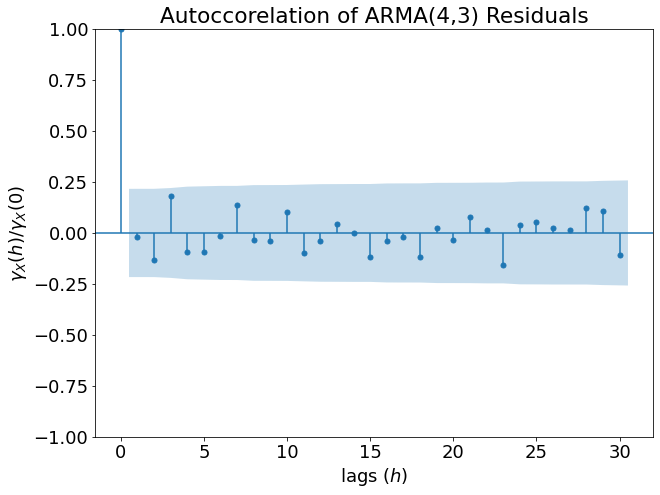

In [44]:
#Plotting ARMA residuals
plot_acf(best_model.resid, lags =30)
plt.xlabel("lags $(h)$")
plt.ylabel("$\gamma_X(h) / \gamma_X(0)$")
plt.title("Autoccorelation of ARMA(4,3) Residuals")
#save figure
plt.show()

# THE END